In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,3)})

In [3]:
import seaborn as sns
sns.set(style='whitegrid')

In [4]:
import bambi as bmb, pandas as pd, numpy as np, arviz as az, pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [6]:
def make_ds(gid, x):
    return  pd.DataFrame({
        'gid': np.repeat(gid,len(x)),
        'x':np.hstack([x for _ in gid])
        #'gid_eps': np.repeat(gid+gid_eps,len(x)),

    })

In [7]:
np.random.seed(42)
x = np.linspace(-50,50,100)

df_meta = pd.Series(
    dict(
        y_sigma = 6,
        gid_slope_mu    = 2,
        gid_slope_sigma = 4,
        
    )
)

gid = np.array([1,2,3,4])

gid_slope = df_meta.gid_slope_mu + df_meta.gid_slope_sigma*np.random.randn(len(gid))
gid_slope

array([3.98685661, 1.4469428 , 4.59075415, 8.09211943])

In [8]:
df_meta['gid_slope_mu_sampled']= np.mean(gid_slope)
df_meta['gid_slope_sig_sampled']= np.std(gid_slope)
df_meta

y_sigma                  6.000000
gid_slope_mu             2.000000
gid_slope_sigma          4.000000
gid_slope_mu_sampled     4.529168
gid_slope_sig_sampled    2.371320
dtype: float64

,gid,x,gid_m,y
395,4,45.959596,8.092119,379.337437
396,4,46.969697,8.092119,370.517831
397,4,47.979798,8.092119,384.662005
398,4,48.989899,8.092119,396.463575
399,4,50.000000,8.092119,404.887855


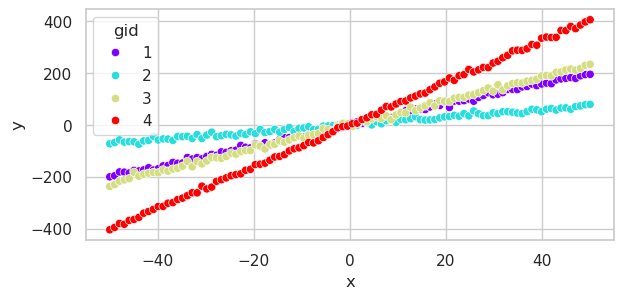

In [9]:
df_raw = (
    make_ds(gid, x)
    .assign(
        
        gid_m = np.repeat(gid_slope,len(x)),
        
        y = lambda df: df.x.mul(df.gid_m)+ (df_meta.y_sigma*np.random.randn(len(df.x)))
    )
)
sns.scatterplot(x='x',y='y',data=df_raw,hue='gid',palette='rainbow',ax=plt.subplot(121))
df_raw.tail()

In [10]:
df_raw.groupby('gid')['gid_m'].unique()

gid
1    [3.9868566120449307]
2    [1.4469427953152614]
3      [4.59075415240277]
4     [8.092119425632102]
Name: gid_m, dtype: object

In [11]:
ans_1=smf.ols('y~x',data=df_raw).fit()
print(ans_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1446.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):          1.35e-134
Time:                        23:55:55   Log-Likelihood:                -2262.5
No. Observations:                 400   AIC:                             4529.
Df Residuals:                     398   BIC:                             4537.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0652      3.470      0.019      0.9

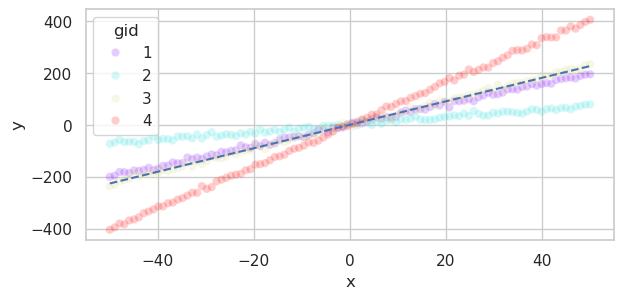

In [12]:
ax=plt.subplot(121)
sns.scatterplot(x='x',y='y',data=df_raw,hue='gid',palette='rainbow',ax=ax,alpha=0.2)

x_test = np.linspace(-50,50,1000)
y_pred = ans_1.predict(pd.DataFrame({'x':x_test}))
plt.plot(x_test,y_pred,ls='--')

In [13]:
ans_2=smf.ols('y~ 0+x*C(gid)',data=df_raw).fit()
print(ans_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.800e+04
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:55:55   Log-Likelihood:                -1264.9
No. Observations:                 400   AIC:                             2546.
Df Residuals:                     392   BIC:                             2578.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(gid)[1]        -0.9537      0.577     -1.651

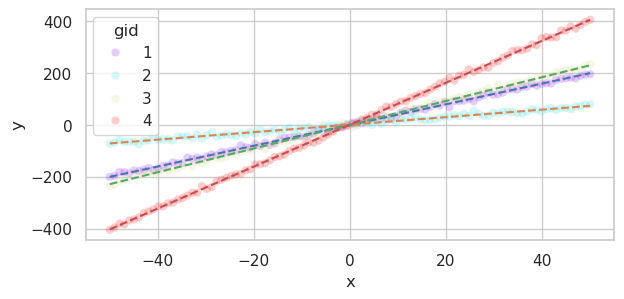

In [14]:
ax=plt.subplot(121)
sns.scatterplot(x='x',y='y',data=df_raw,hue='gid',palette='rainbow',ax=ax,alpha=0.2)

for g in gid:
    x_test = np.linspace(-50,50,1000)
    ds_test = make_ds([g],x_test)

    y_pred = ans_2.predict(ds_test)
    plt.plot(ds_test.x,y_pred,ls='--')

In [15]:
ans_3=smf.mixedlm(
    'y~ 0 + x', groups='gid', re_formula='~0+x',
    data=df_raw, 
).fit()
print(ans_3.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 400     Method:             REML      
No. Groups:       4       Scale:              33.3816   
Min. group size:  100     Log-Likelihood:     -1287.1516
Max. group size:  100     Converged:          Yes       
Mean group size:  100.0                                 
----------------------------------------------------------
        Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
----------------------------------------------------------
x       4.526      1.366   3.313   0.001    1.848    7.204
x Var   7.467      1.060                                  



dir(ans_3)

In [16]:
ans_mixedlm = (
    pd.DataFrame(ans_3.random_effects).T
    .rename(columns={'x':'x|gid'})
    .assign(
        x_shared = ans_3.params['x'] ,
        total = lambda df: df.sum(axis=1),
        ground_truth = pd.Series(gid_slope,index = gid)
    )     
)
ans_mixedlm

,x|gid,x_shared,total,ground_truth
1,-0.528897,4.526124,3.997227,3.986857
2,-3.079016,4.526124,1.447108,1.446943
3,0.054229,4.526124,4.580353,4.590754
4,3.553683,4.526124,8.079807,8.092119


# PyMC

In [17]:
idx_g = pd.Categorical(df_raw['gid'], categories=gid).codes
idx_g.shape

(400,)

In [18]:
df_meta

y_sigma                  6.000000
gid_slope_mu             2.000000
gid_slope_sigma          4.000000
gid_slope_mu_sampled     4.529168
gid_slope_sig_sampled    2.371320
dtype: float64

In [19]:

with pm.Model(coords={'gid':gid, 'idx_g':idx_g}) as model:
        
    hyper_mu = pm.Normal('hyper_mu', mu=0, sigma=5)
    #hyper_sig = pm.Exponential('hyper_sig', lam=5)    
    hyper_sig =pm.HalfStudentT('hyper_sig', nu=5,sigma=5)   
    
    mu_xg = pm.Normal('mu_x|g', mu=hyper_mu, sigma=hyper_sig, dims='gid')            
    #y_sigma = pm.Exponential('y_sigma', lam=5)            
    y_sigma = pm.HalfStudentT('y_sigma', nu=5,sigma=5)            
    
    y_hat = mu_xg[idx_g]*df_raw.x 
    
    y = pm.Normal('y', mu=y_hat, sigma=y_sigma, observed=df_raw.y)
    prior_trace = pm.sample_prior_predictive(4000)
        

Sampling: [hyper_mu, hyper_sig, mu_x|g, y, y_sigma]


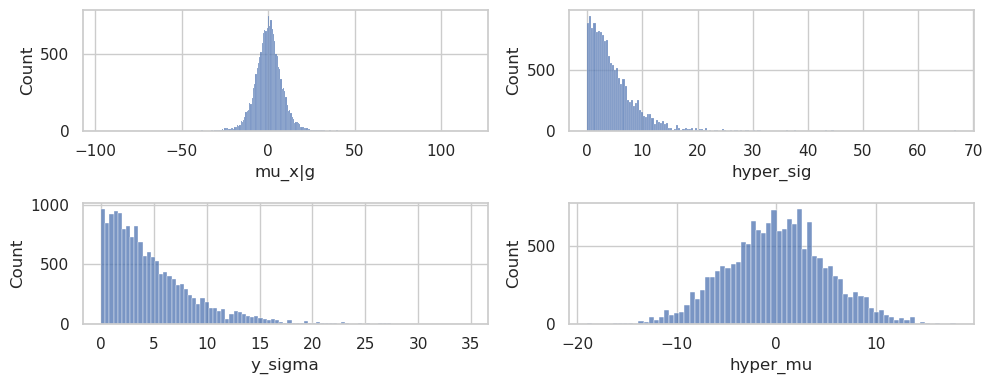

In [20]:
plt.figure(figsize=(10,4))
df_prior = prior_trace.prior.to_dataframe()
for cnt, key in enumerate(df_prior.columns,1):
    sns.histplot(df_prior[key],ax=plt.subplot(2,2,cnt))#.set(title=key)
plt.tight_layout()    

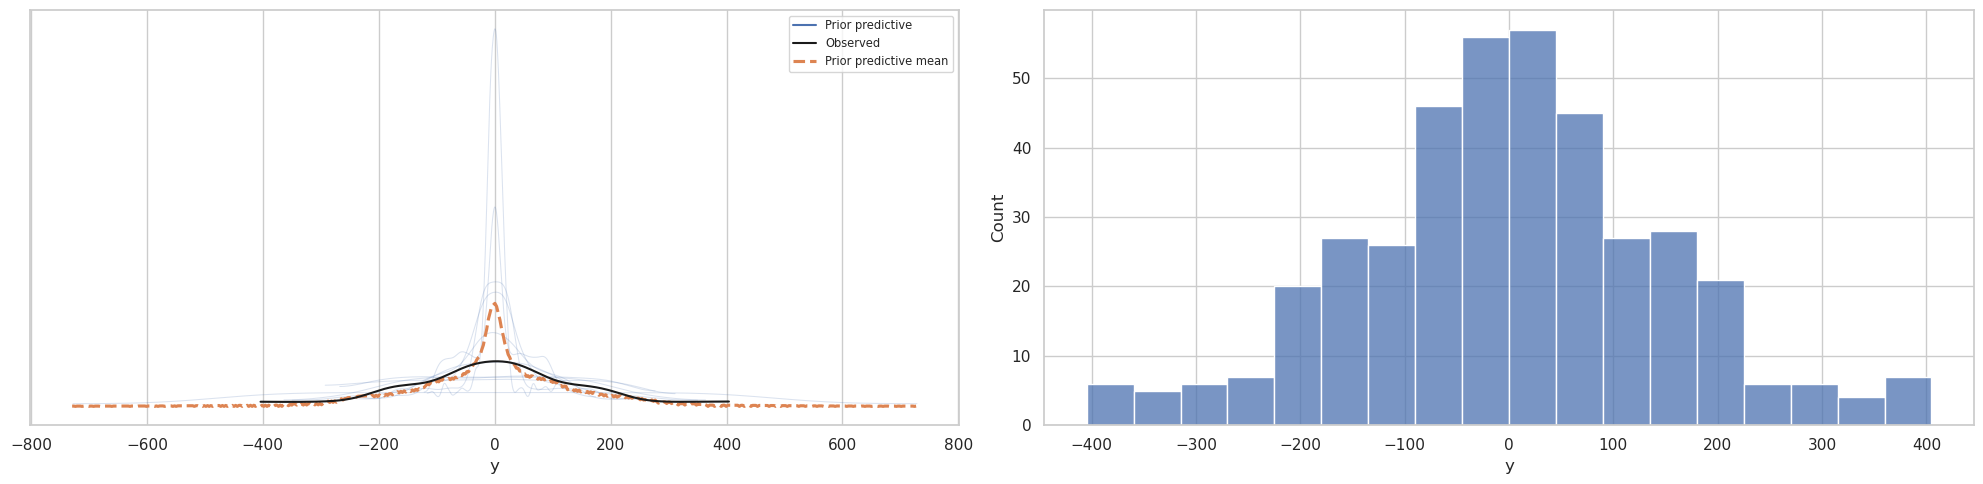

In [21]:
plt.figure(figsize=(20,5))
az.plot_ppc(prior_trace, num_pp_samples=10,group='prior',ax=plt.subplot(121))
sns.histplot(df_raw.y,ax=plt.subplot(122))
plt.tight_layout()

In [22]:
with model:
    trace = pm.sample(4000, tune=1000) #
    pm.sample_posterior_predictive(trace,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hyper_mu, hyper_sig, mu_x|g, y_sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 6 seconds.
Sampling: [y]


In [23]:
ans_mixedlm 

,x|gid,x_shared,total,ground_truth
1,-0.528897,4.526124,3.997227,3.986857
2,-3.079016,4.526124,1.447108,1.446943
3,0.054229,4.526124,4.580353,4.590754
4,3.553683,4.526124,8.079807,8.092119


In [24]:
az.summary(trace, kind='stats',var_names=['mu_x|g'])

,mean,sd,hdi_3%,hdi_97%
mu_x|g[1],3.997,0.02,3.959,4.033
mu_x|g[2],1.447,0.02,1.409,1.484
mu_x|g[3],4.580,0.02,4.542,4.617
mu_x|g[4],8.080,0.02,8.042,8.117


In [25]:
df_meta

y_sigma                  6.000000
gid_slope_mu             2.000000
gid_slope_sigma          4.000000
gid_slope_mu_sampled     4.529168
gid_slope_sig_sampled    2.371320
dtype: float64

In [26]:
az.summary(trace, kind='stats',var_names=['~mu_x|g'])

,mean,sd,hdi_3%,hdi_97%
hyper_mu,3.942,1.824,0.383,7.337
hyper_sig,3.662,1.700,1.407,6.765
y_sigma,5.788,0.206,5.398,6.170


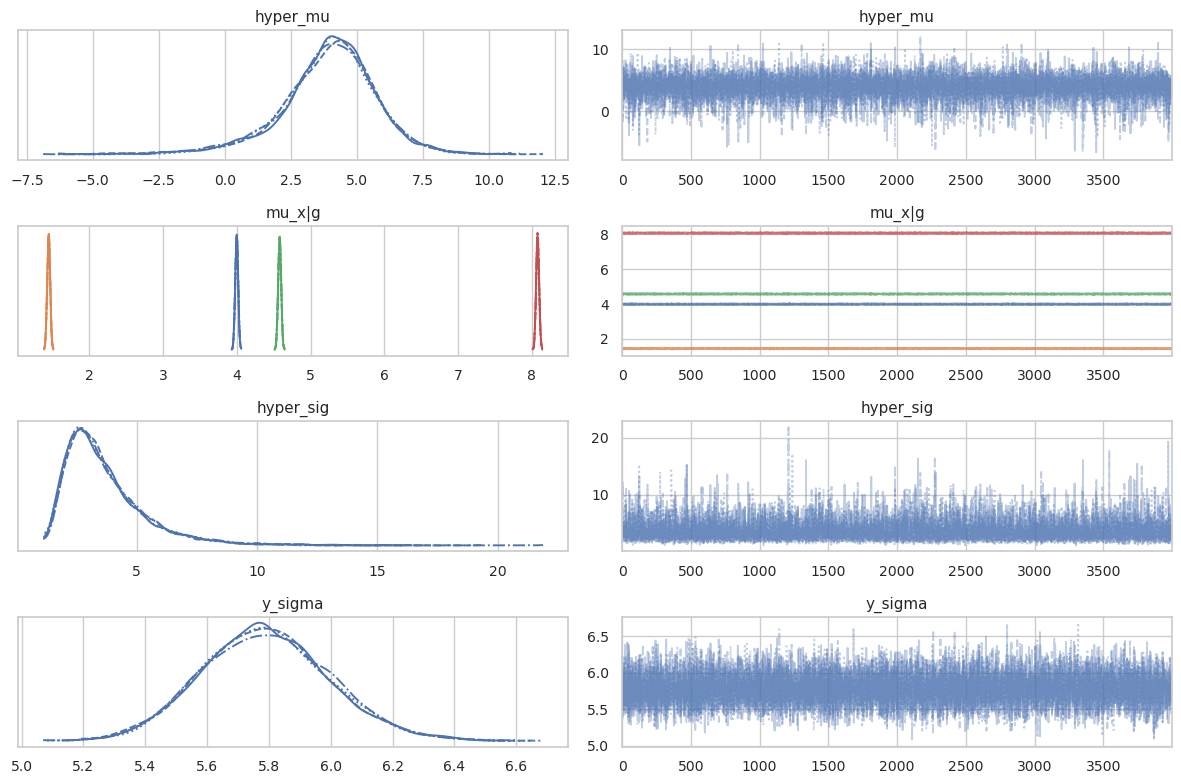

In [27]:
az.plot_trace(trace); plt.tight_layout()

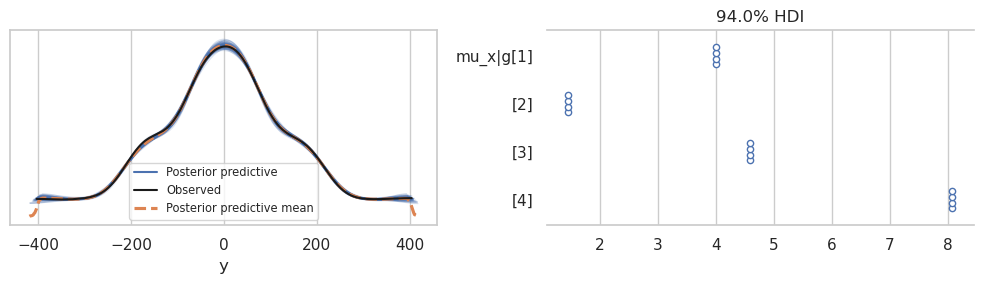

In [28]:
plt.figure(figsize=(10,3))
az.plot_ppc(trace, num_pp_samples=100,ax=plt.subplot(121))
az.plot_forest(trace, var_names=['mu_x|g'],figsize=(10,3),ax=plt.subplot(122))
plt.tight_layout()

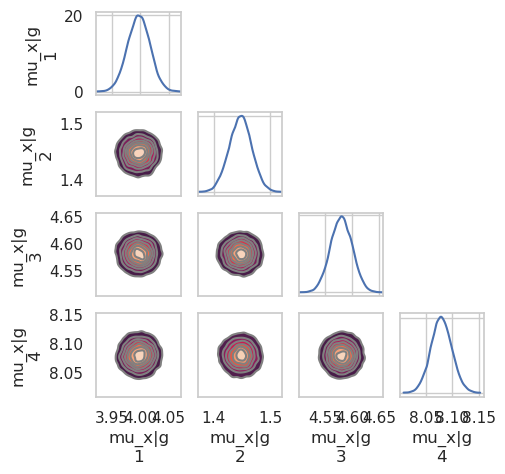

In [29]:
az.plot_pair(trace, var_names=['mu_x|g'],figsize=(5,5),kind='kde',marginals=True);

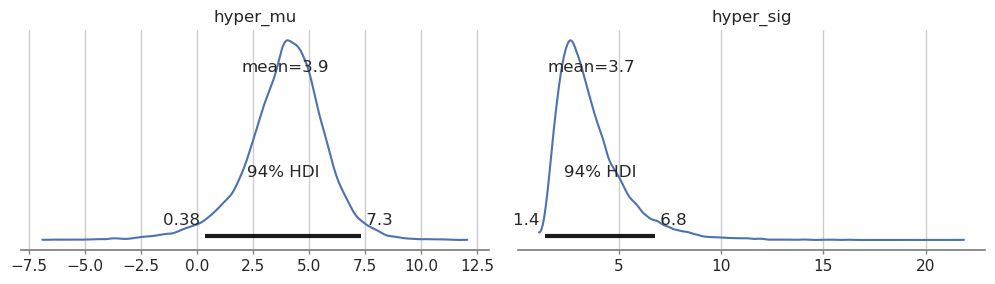

In [30]:
az.plot_posterior(trace,var_names=['hyper_mu','hyper_sig'],figsize=(10,3));
plt.tight_layout()

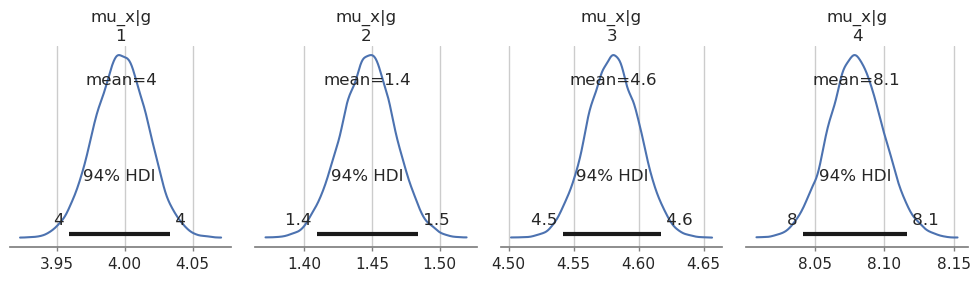

In [31]:
az.plot_posterior(trace,var_names=['mu_x|g'],figsize=(10,3));
plt.tight_layout()

# BmB

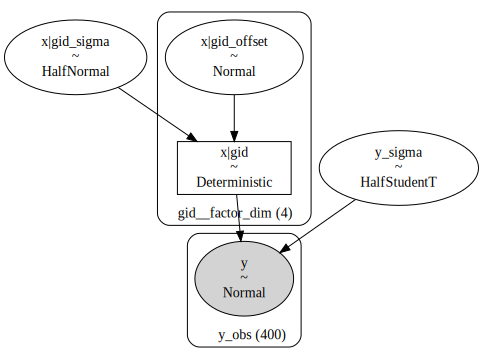

In [32]:
mdl1 = bmb.Model('y~ 0 + (0+x|gid)', data=df_raw)
mdl1.build(); mdl1.graph()

In [33]:
mdl1

       Formula: y~ 0 + (0+x|gid)
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Group-level effects
            x|gid ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 12.7777))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 149.0272)

In [34]:
res1 = mdl1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x|gid_sigma, x|gid_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.


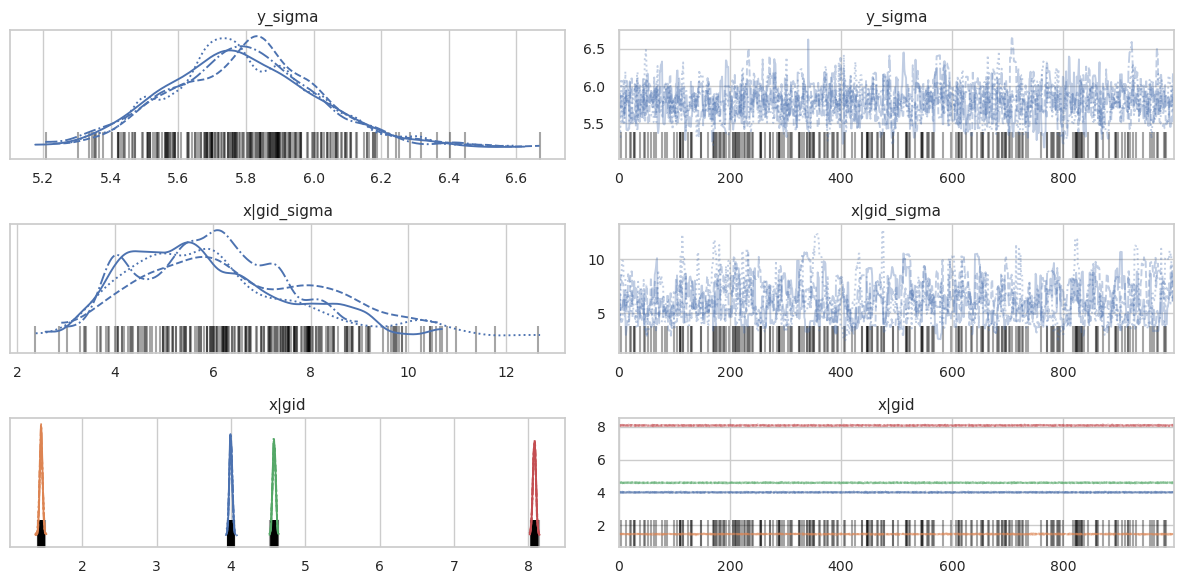

In [35]:
az.plot_trace(res1); plt.tight_layout()

In [36]:
az.summary(res1,kind='stats')

,mean,sd,hdi_3%,hdi_97%
y_sigma,5.791,0.220,5.365,6.190
x|gid_sigma,6.124,1.785,3.263,9.592
x|gid[1],3.997,0.020,3.960,4.033
x|gid[2],1.447,0.020,1.410,1.484
x|gid[3],4.580,0.020,4.545,4.618
x|gid[4],8.080,0.020,8.042,8.119


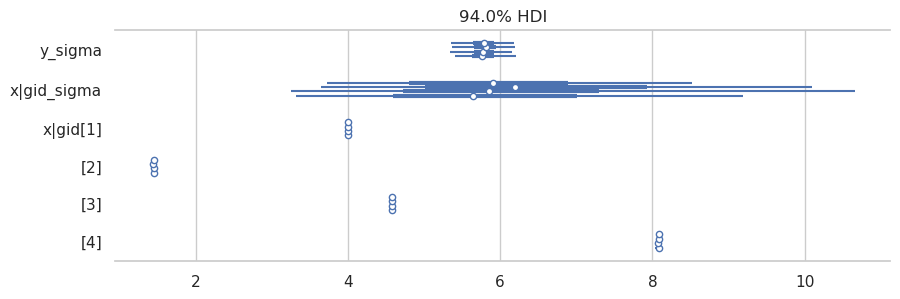

In [37]:
az.plot_forest(res1,figsize=(10,3));